# Comparative Analysis of Benchmark Strategies
This notebook performs a comparative analysis of different benchmark strategies using JSON metrics files.

## Section 1: Import Required Libraries
Import the necessary libraries for data loading, manipulation, and visualization.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set_theme(style="whitegrid")

## Section 2: Load Benchmark Metrics JSON Files
Use `os.listdir()` to find all JSON files in the `benchmarks` folder and load each into a pandas DataFrame, capturing the strategy name.

In [26]:
# Path to benchmarks folder
benchmarks_dir = "benchmarks"

# Load JSON files into DataFrames
data_frames = []
import json
for file in os.listdir(benchmarks_dir):
    if file.endswith('.json'):
        strategy = file.replace('metrics_', '').replace('.json', '')
        json_path = os.path.join(benchmarks_dir, file)
        with open(json_path, 'r') as f:
            raw = json.load(f)
        # Normalize raw JSON into DataFrame
        df = pd.json_normalize(raw)
        df['strategy'] = strategy
        data_frames.append(df)

# Display count of loaded DataFrames
print(f"Loaded {len(data_frames)} benchmark files.")

Loaded 7 benchmark files.


## Section 3: Combine and Normalize Data
Concatenate individual DataFrames into a single DataFrame and flatten nested JSON metrics into columns. Normalize latency to milliseconds.

In [31]:
# Combine into single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)
# Replace dots in column names
combined_df.columns = combined_df.columns.str.replace('.', '_', regex=False)

# Convert time-based metrics from nanoseconds to milliseconds
ns_cols = ['latencies_total','latencies_mean','latencies_50th','latencies_95th','latencies_99th','latencies_max','duration','wait']
for col in ns_cols:
    if col in combined_df.columns:
        combined_df[col + '_ms'] = combined_df[col] / 1e6

# Create a unified latency_ms (mean latency in ms)
if 'latencies_mean_ms' in combined_df.columns:
    combined_df['latency_ms'] = combined_df['latencies_mean_ms']

combined_df

,earliest,latest,end,duration,wait,requests,rate,throughput,success,errors,...,strategy,latencies_total_ms,latencies_mean_ms,latencies_50th_ms,latencies_95th_ms,latencies_99th_ms,latencies_max_ms,duration_ms,wait_ms,latency_ms
0,2025-09-03T21:44:59.9962035-07:00,2025-09-03T21:46:59.994510291-07:00,2025-09-03T21:47:00.34431175-07:00,119998306791,349801459,72000,600.008466,598.264493,1,[],...,leastlatency,1.713034e+07,237.921350,236.435799,369.153898,401.829631,654.781709,119998.306791,349.801459,237.921350
1,2025-09-03T21:21:50.12861875-07:00,2025-09-03T21:23:50.127062125-07:00,2025-09-03T21:23:50.264673416-07:00,119998443375,137611291,72000,600.007783,599.320497,1,[],...,prequal,6.347710e+06,88.162644,87.250831,123.972475,141.200899,240.101333,119998.443375,137.611291,88.162644
2,2025-09-03T21:38:41.898662667-07:00,2025-09-03T21:40:41.896882042-07:00,2025-09-03T21:40:42.043803417-07:00,119998219375,146921375,72000,600.008903,599.275173,1,[],...,random,6.194233e+06,86.031018,77.452098,152.166657,178.004830,239.819834,119998.219375,146.921375,86.031018
3,2025-09-03T21:40:47.83939-07:00,2025-09-03T21:42:47.837672084-07:00,2025-09-03T21:42:48.059387084-07:00,119998282084,221715000,72000,600.008590,598.902028,1,[],...,roundrobin,9.170562e+06,127.368916,121.770120,201.890113,236.496899,366.241292,119998.282084,221.715000,127.368916
4,2025-09-03T21:42:53.977215458-07:00,2025-09-03T21:44:53.975425458-07:00,2025-09-03T21:44:54.197975333-07:00,119998210000,222549875,72000,600.008950,598.898228,1,[],...,leastrif,9.232178e+06,128.224695,123.092694,207.499842,233.126156,279.975417,119998.210000,222.549875,128.224695
5,2025-09-03T21:47:06.008718875-07:00,2025-09-03T21:49:06.006844542-07:00,2025-09-03T21:49:06.1577545-07:00,119998125667,150909958,72000,600.009372,599.255746,1,[],...,power2_leastrif,8.190868e+06,113.762052,101.648783,208.145993,249.544276,336.678750,119998.125667,150.909958,113.762052
6,2025-09-03T21:49:11.861375167-07:00,2025-09-03T21:51:11.859515084-07:00,2025-09-03T21:51:12.003966-07:00,119998139917,144450916,72000,600.009301,599.287892,1,[],...,power2_leastlatency,7.767148e+06,107.877060,107.456021,144.210041,159.718466,202.934666,119998.139917,144.450916,107.877060


## Section 4: Compute Summary Statistics
Group the combined data by strategy and compute mean, median, and standard deviation for each key performance metric.

In [33]:
# Create summary DataFrame (one row per strategy)
summary_df = combined_df.set_index('strategy')[[  
    'latency_ms',      # mean latency in ms
    'latencies_50th_ms',  # median latency
    'latencies_95th_ms',  # 95th percentile
    'latencies_99th_ms',  # 99th percentile
    'latencies_max_ms',   # max latency
    'throughput',      # requests per second
    'bytes_in_mean'    # mean bytes in
]].reset_index()
summary_df

,strategy,latency_ms,latencies_50th_ms,latencies_95th_ms,latencies_99th_ms,latencies_max_ms,throughput,bytes_in_mean
0,leastlatency,237.921350,236.435799,369.153898,401.829631,654.781709,598.264493,81.956444
1,prequal,88.162644,87.250831,123.972475,141.200899,240.101333,599.320497,80.261750
2,random,86.031018,77.452098,152.166657,178.004830,239.819834,599.275173,79.819333
3,roundrobin,127.368916,121.770120,201.890113,236.496899,366.241292,598.902028,80.715056
4,leastrif,128.224695,123.092694,207.499842,233.126156,279.975417,598.898228,80.695597
5,power2_leastrif,113.762052,101.648783,208.145993,249.544276,336.678750,599.255746,80.294806
6,power2_leastlatency,107.877060,107.456021,144.210041,159.718466,202.934666,599.287892,80.504639


## Section 5: Plot Latency Comparison
Visualize average latency across all strategies with error bars for standard deviation.

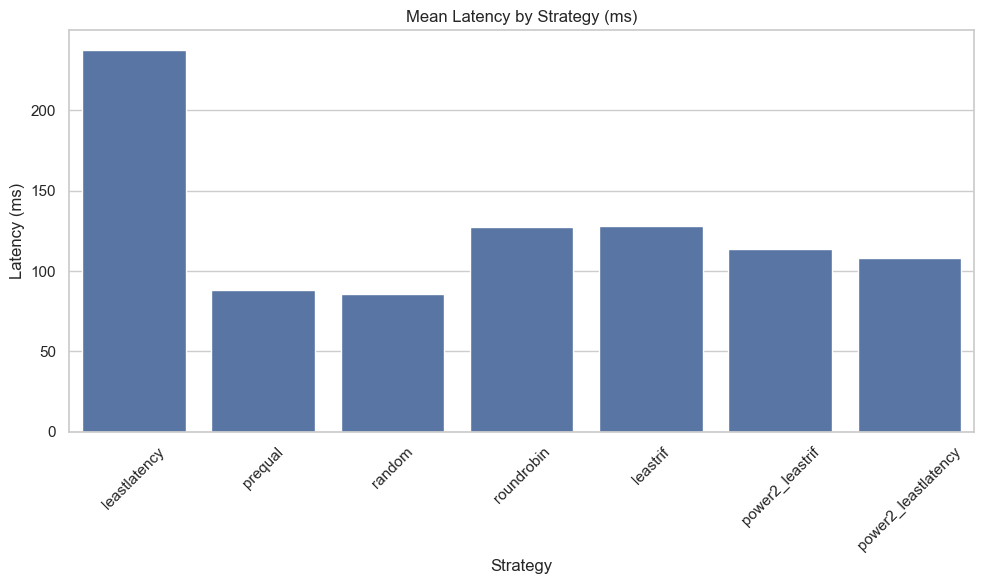

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='strategy', y='latency_ms', data=summary_df)
plt.title('Mean Latency by Strategy (ms)')
plt.xlabel('Strategy')
plt.ylabel('Latency (ms)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

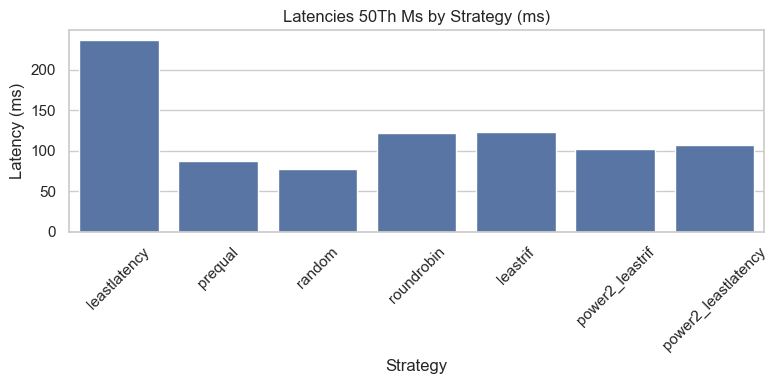

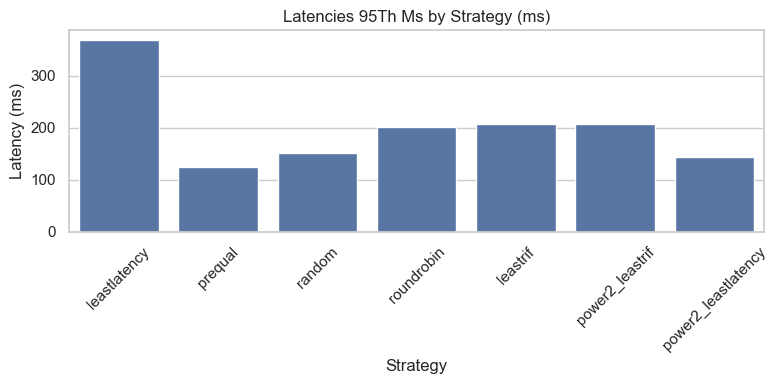

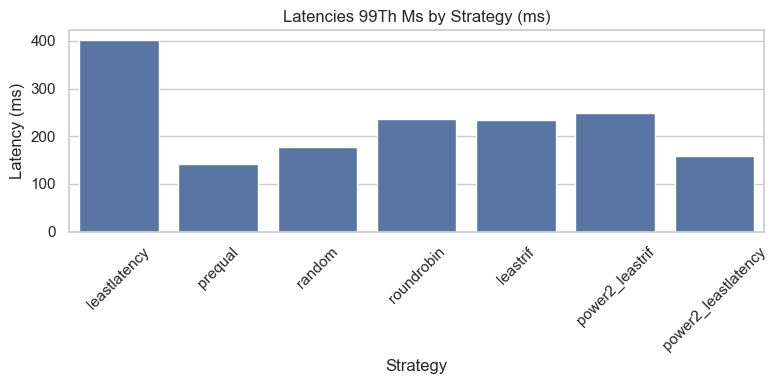

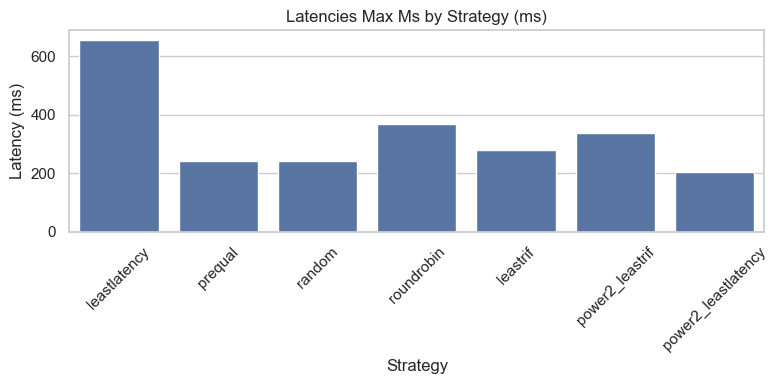

In [41]:
# Plot additional latency metrics
metrics = ['latencies_50th_ms','latencies_95th_ms','latencies_99th_ms','latencies_max_ms']
for metric in metrics:
    plt.figure(figsize=(8,4))
    sns.barplot(x='strategy', y=metric, data=summary_df)
    plt.title(f"{metric.replace('_',' ').title()} by Strategy (ms)")
    plt.xlabel('Strategy')
    plt.ylabel('Latency (ms)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()